In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt #version 3.4.2 necessary, for just one feature though 
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline     
sns.set(color_codes=True)
import tensorflow as tf

In [2]:
!wget -O cardio_train.csv https://github.com/yatharthsood00/cvdisease-DT/blob/master/cardio_train.csv?raw=true

--2021-08-06 00:58:44--  https://github.com/yatharthsood00/cvdisease-DT/blob/master/cardio_train.csv?raw=true
Resolving github.com (github.com)... 13.234.210.38
Connecting to github.com (github.com)|13.234.210.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/yatharthsood00/cvdisease-DT/raw/master/cardio_train.csv [following]
--2021-08-06 00:58:44--  https://github.com/yatharthsood00/cvdisease-DT/raw/master/cardio_train.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yatharthsood00/cvdisease-DT/master/cardio_train.csv [following]
--2021-08-06 00:58:45--  https://raw.githubusercontent.com/yatharthsood00/cvdisease-DT/master/cardio_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133

In [3]:
cv = pd.read_csv("cardio_train.csv", delimiter = ';') #kaggle won't let you use !wget so easily now, so here we are
cv.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [4]:
cv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


### Outliers

We can expect outliers in age, height and weight. But first, we will look at blood pressures

In [5]:
cv.describe()

id           age        gender        height        weight  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   49972.419900  19468.865814      1.349571    164.359229     74.205690   
std    28851.302323   2467.251667      0.476838      8.210126     14.395757   
min        0.000000  10798.000000      1.000000     55.000000     10.000000   
25%    25006.750000  17664.000000      1.000000    159.000000     65.000000   
50%    50001.500000  19703.000000      1.000000    165.000000     72.000000   
75%    74889.250000  21327.000000      2.000000    170.000000     82.000000   
max    99999.000000  23713.000000      2.000000    250.000000    200.000000   

              ap_hi         ap_lo   cholesterol          gluc         smoke  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean     128.817286     96.630414      1.366871      1.226457      0.088129   
std      154.011419    188.472530      0.680250      0.572270      0.283484   
min     -150.000000    -70.000000      1.000000      1.000000      0.000000   
25%      120.000000     80.000000      1.000000      1.000000      0.000000   
50%      120.000000     80.000000      1.000000      1.000000      0.000000   
75%      140.000000     90.000000      2.000000      1.000000      0.000000   
max    16020.000000  11000.000000      3.000000      3.000000      1.000000   

               alco        active        cardio  
count  70000.000000  70000.000000  70000.000000  
mean       0.053771      0.803729      0.499700  
std        0.225568      0.397179      0.500003  
min        0.000000      0.000000      0.000000  
25%        0.000000      1.000000      0.000000  
50%        0.000000      1.000000      0.000000  
75%        0.000000      1.000000      1.000000  
max        1.000000      1.000000      1.000000

Some outliers can be seen in ap_lo (diastolic blood pressure) and ap_hi (systolic blood pressure), most likely erroneous entries (a BP of 200/11000 or is very much unrealistic). We take a look at these entries below.

The condition for low BP (Hypotension) is a BP lower than 90/60, and for a Hypertensive Crisis (extremely high BP), it is 180/120. We will take all those cases into account, as well as some anomalous readings that are possible to achieve, while discarding impossible readings.

In [6]:
damn_lo = cv.loc[(cv['ap_lo'] > 200) | (cv['ap_lo'] < 30)]
damn_lo = damn_lo.sort_values(by='ap_lo', ascending=True)
damn_lo.shape

(1006, 13)

In [7]:
damn_hi = cv.loc[(cv['ap_hi'] > 250) | (cv['ap_hi'] < 60)]
damn_hi = damn_hi.sort_values(by='ap_hi', ascending=False)
damn_hi.shape

(228, 13)

We can discard these entries from our dataset and proceed, without medically impossible outliers. This rather simplistic approach will keep outliers that are possible but are of particular interest (like people with high BP, as they have a very high risk of cardiovascular disease) intact.

In [8]:
d = [damn_lo, damn_hi]
damn = pd.concat(d)

In [9]:
cv = cv[cv['ap_lo'] < cv['ap_hi']]

In [10]:
damn_bp = cv['id'].isin(damn['id'])
cv.drop(cv[damn_bp].index, inplace = True)
cv.shape

(68678, 13)

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cv[['height', 'weight']] = scaler.fit_transform(cv[['height', 'weight']])
cv.head()

id    age  gender    height    weight  ap_hi  ap_lo  cholesterol  gluc  \
0   0  18393       2  0.444661 -0.845623    110     80            1     1   
1   1  20228       1 -1.021712  0.759252    140     90            3     1   
2   2  18857       1  0.078068 -0.706069    130     70            3     1   
3   3  17623       2  0.566859  0.549920    150    100            1     1   
4   4  17474       1 -1.021712 -1.264286    100     60            1     1   

   smoke  alco  active  cardio  
0      0     0       1       0  
1      0     0       1       1  
2      0     0       0       1  
3      0     0       1       1  
4      0     0       0       0

In [12]:
cv_melt = pd.melt(cv, id_vars=['id'], value_vars = ['height', 'weight'], var_name = 'features', value_name = 'vals')
cv_melt

id features      vals
0           0   height  0.444661
1           1   height -1.021712
2           2   height  0.078068
3           3   height  0.566859
4           4   height -1.021712
...       ...      ...       ...
137351  99993   weight  0.131257
137352  99995   weight  3.620115
137353  99996   weight  2.154795
137354  99998   weight -0.147852
137355  99999   weight -0.147852

[137356 rows x 3 columns]

<AxesSubplot:xlabel='features', ylabel='vals'>

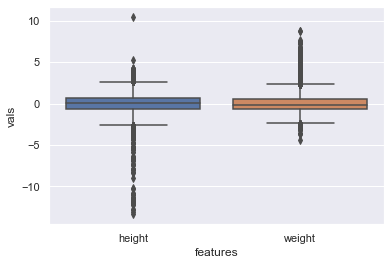

In [13]:
sns.boxplot(x = 'features', y = 'vals', data = cv_melt)

In [14]:
hwlist = ['height', 'weight']
bound = pd.DataFrame(index=["lower_bound", "upper_bound"])
for each in hwlist:
    Q1 = cv[each].quantile(0.025)
    Q3 = cv[each].quantile(0.975)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    bound[each] = [lower_bound, upper_bound]
bound

height    weight
lower_bound -7.253797 -7.474454
upper_bound  7.409932  8.155631

In [15]:
cv = cv[(cv['height'] >= bound['height']['lower_bound']) & (cv['height'] <= bound['height']['upper_bound'])]
cv = cv[(cv['weight'] >= bound['weight']['lower_bound']) & (cv['weight'] <= bound['height']['upper_bound'])]

In [16]:
cv_melt2 = pd.melt(cv, id_vars=['id'], value_vars = ['height', 'weight'], var_name = 'features', value_name = 'vals')
cv_melt2

id features      vals
0           0   height  0.444661
1           1   height -1.021712
2           2   height  0.078068
3           3   height  0.566859
4           4   height -1.021712
...       ...      ...       ...
137281  99993   weight  0.131257
137282  99995   weight  3.620115
137283  99996   weight  2.154795
137284  99998   weight -0.147852
137285  99999   weight -0.147852

[137286 rows x 3 columns]

<AxesSubplot:xlabel='features', ylabel='vals'>

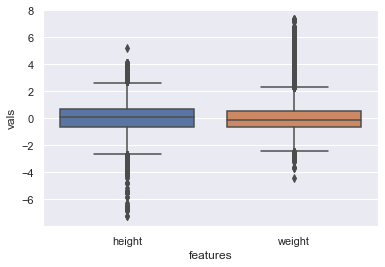

In [17]:
sns.boxplot(x = 'features', y = 'vals', data = cv_melt2)

The most extreme outliers are gone from the height and weight columns.

In [18]:
cv.shape

(68643, 13)

In [19]:
# we inverse the scaling on height and weight
cv[['height', 'weight']] = scaler.inverse_transform(cv[['height', 'weight']])
cv.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2   168.0    62.0    110     80            1     1      0   
1   1  20228       1   156.0    85.0    140     90            3     1      0   
2   2  18857       1   165.0    64.0    130     70            3     1      0   
3   3  17623       2   169.0    82.0    150    100            1     1      0   
4   4  17474       1   156.0    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

# Correlation

<AxesSubplot:>

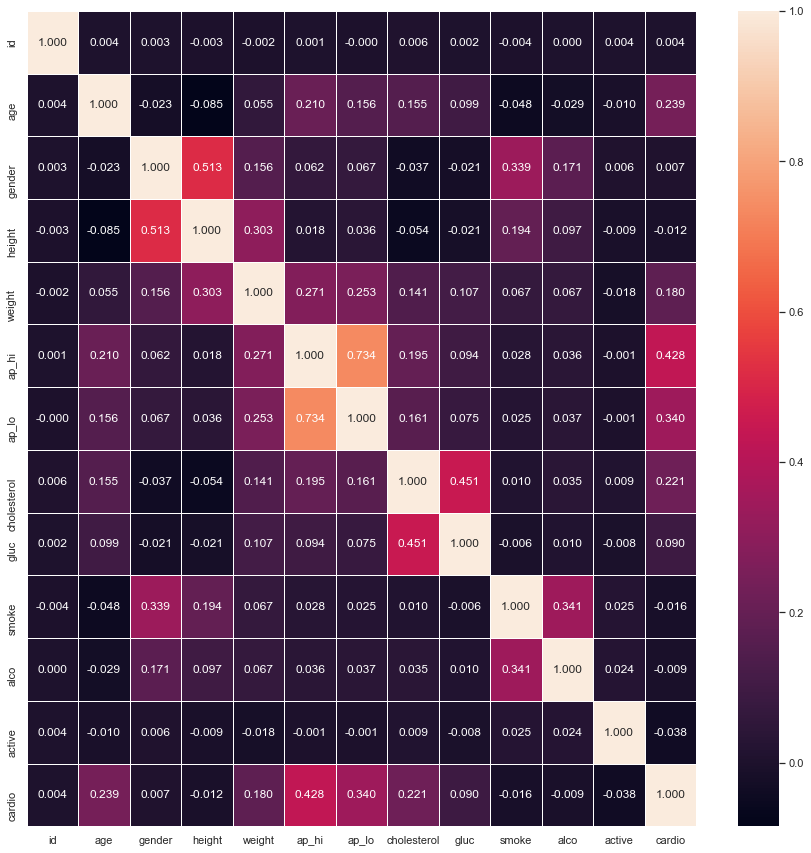

In [20]:
cvc = cv.corr()
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(cvc, annot=True, fmt='.3f', linewidths = 0.5, ax=ax)

Correlating with `cardio`, `age`, `ap_hi`, `ap_lo` have a good correlation coefficient. Height and weight need to be incorporated in a better manner in the dataset to achieve this. For this purpose, we create a new column, `bmi`.

BMI is Body Mass Index, and it is measured by dividing one's weight in kg (as we have in `weight`) with their height in m (we can achieve that by dividing `height` by 100), squared.

In [21]:
# we inverse the scaling on height and weight first to perform the calculations.
cv[['height', 'weight']] = scaler.inverse_transform(cv[['height', 'weight']])
cv.head()

id    age  gender       height       weight  ap_hi  ap_lo  cholesterol  \
0   0  18393       2  1539.181959   962.661786    110     80            1   
1   1  20228       1  1440.980472  1292.282530    140     90            3   
2   2  18857       1  1514.631587   991.324459    130     70            3   
3   3  17623       2  1547.365416  1249.288520    150    100            1   
4   4  17474       1  1440.980472   876.673766    100     60            1   

   gluc  smoke  alco  active  cardio  
0     1      0     0       1       0  
1     1      0     0       1       1  
2     1      0     0       0       1  
3     1      0     0       1       1  
4     1      0     0       0       0

In [22]:
cv['bmi'] = cv['weight']/((cv['height']/100)*(cv['height']/100))
cv.head()

id    age  gender       height       weight  ap_hi  ap_lo  cholesterol  \
0   0  18393       2  1539.181959   962.661786    110     80            1   
1   1  20228       1  1440.980472  1292.282530    140     90            3   
2   2  18857       1  1514.631587   991.324459    130     70            3   
3   3  17623       2  1547.365416  1249.288520    150    100            1   
4   4  17474       1  1440.980472   876.673766    100     60            1   

   gluc  smoke  alco  active  cardio       bmi  
0     1      0     0       1       0  4.063440  
1     1      0     0       1       1  6.223594  
2     1      0     0       0       1  4.321174  
3     1      0     0       1       1  5.217674  
4     1      0     0       0       0  4.222035

In [23]:
cv.drop(['height', 'weight'], inplace=True, axis=1)

In [24]:
print(list(cv.columns.values))

['id', 'age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi']


In [25]:
cv = cv[list(('id', 'age', 'gender', 'bmi', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'))]

<AxesSubplot:>

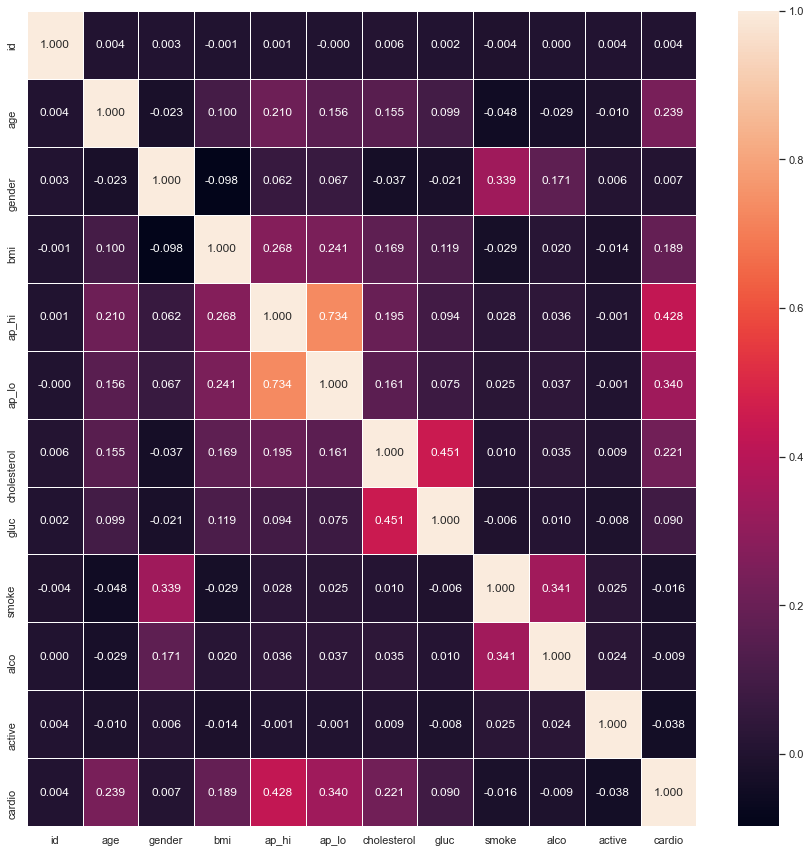

In [26]:
cvc = cv.corr()
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(cvc, annot=True, fmt='.3f', linewidths = 0.5, ax=ax)

With `bmi`, we have a more consistent statistic that also incorporates the patient's height into account, along with slightly higher correlation too.

#### `gluc` and `cholesterol`,  and probabilities

Glucose and cholesterol levels are two quantities that can contribute to cardiovascular disease, and this dataset has `gluc` and `cholesterol` metrics that measure these values for each patient with multiple levels. We can examine this metric to evaluate the increase in probability in getting cardiovascular disease with increases in these metrics.

In [27]:
gluch = cv[['gluc', 'cholesterol', 'cardio']].copy()

Text(0.02, 0.5, 'Number of people')

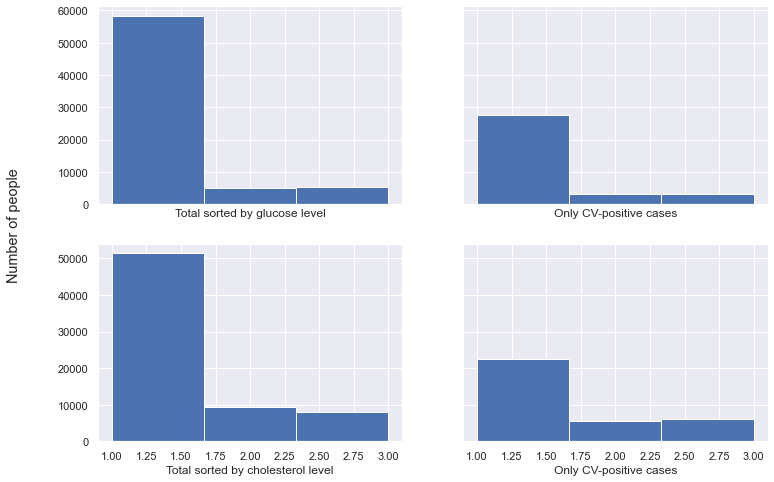

In [28]:
fig, axs = plt.subplots(2,2,figsize=(12,8), sharex=True, sharey='row')

axs[0,0].hist(gluch["gluc"], bins=3)
axs[0,0].set_xlabel("Total sorted by glucose level")

axs[0,1].hist(gluch["gluc"].loc[gluch['cardio'] == 1], bins=3)
axs[0,1].set_xlabel("Only CV-positive cases")

axs[1,0].hist(gluch["cholesterol"], bins=3)
axs[1,0].set_xlabel("Total sorted by cholesterol level")

axs[1,1].set_xlabel("Only CV-positive cases")
axs[1,1].hist(gluch["cholesterol"].loc[gluch['cardio'] == 1], bins=3)

fig.supylabel("Number of people") #backspace/comment this out for matplotlib ver < 3.4

We can see that as the `gluc` and `cholesterol` values increase from 1, the chances of having cardiovascular disease increases, and we can illustrate that in a much better way using simple probabilities:

In [29]:
cardio_pos = gluch.loc[gluch['cardio'] == 1].copy()
gl = np.asarray(gluch['gluc'].value_counts(sort=False))
gl_pos = np.asarray(cardio_pos['gluc'].value_counts(sort=False))
ch = np.asarray(gluch['cholesterol'].value_counts(sort=False))
ch_pos = np.asarray(cardio_pos['cholesterol'].value_counts(sort=False))

In [30]:
print("Probabilities: ", "\n")
print("1. Glucose levels: ")
print("[1       2       3]")
glp = np.round(gl_pos/gl, 3)
print(glp, "\n")
print("2. Cholesterol levels: ")
print("[1       2       3]")
cop = np.round(ch_pos/ch, 3)
print(cop)

Probabilities:  

1. Glucose levels: 
[1       2       3]
[0.476 0.589 0.617] 

2. Cholesterol levels: 
[1       2       3]
[0.435 0.596 0.762]


Probability rises fairly steeply when glucose, and especially, cholesterol levels are elevated, and this backs up the original assumption made.

# Train-Test Split and Model Implementation

In [31]:
y = np.asarray(cv['cardio'])
y

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

In [32]:
X = np.asarray(cv[['age', 'gender', 'bmi', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']])
X[0:5]

array([[1.83930000e+04, 2.00000000e+00, 4.06343955e+00, 1.10000000e+02,
        8.00000000e+01, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00],
       [2.02280000e+04, 1.00000000e+00, 6.22359442e+00, 1.40000000e+02,
        9.00000000e+01, 3.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00],
       [1.88570000e+04, 1.00000000e+00, 4.32117448e+00, 1.30000000e+02,
        7.00000000e+01, 3.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.76230000e+04, 2.00000000e+00, 5.21767443e+00, 1.50000000e+02,
        1.00000000e+02, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00],
       [1.74740000e+04, 1.00000000e+00, 4.22203491e+00, 1.00000000e+02,
        6.00000000e+01, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [33]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.43435757,  1.36688389, -1.0402247 , -0.99897442, -0.13770578,
        -0.53720325, -0.39495783, -0.31055752, -0.23739194,  0.49469963],
       [ 0.30917332, -0.73159104,  1.38436129,  0.79823542,  0.91876244,
         2.40892727, -0.39495783, -0.31055752, -0.23739194,  0.49469963],
       [-0.24634758, -0.73159104, -0.75093966,  0.19916547, -1.194174  ,
         2.40892727, -0.39495783, -0.31055752, -0.23739194, -2.02142862],
       [-0.7463569 ,  1.36688389,  0.25530358,  1.39730536,  1.97523066,
        -0.53720325, -0.39495783, -0.31055752, -0.23739194,  0.49469963],
       [-0.8067308 , -0.73159104, -0.8622152 , -1.59804437, -2.25064222,
        -0.53720325, -0.39495783, -0.31055752, -0.23739194, -2.02142862]])

After splitting the dataset into inputs/known quantities (X) and the variable to predict (y), we split using `scikit-learn`'s `train_test_split`. We use an 80/20 split between `train` and `test` sets, with a `random-state` of 0.

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (54914, 10) (54914,)
Test set: (13729, 10) (13729,)


# 1. Logistic Regression

The first model we evaluate is a simple Logistic Regression.

In [35]:
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
LogReg

LogisticRegression(C=0.01, solver='sag')

In [36]:
y_pred_LR = LogReg.predict(X_test)
y_pred_LR

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [37]:
y_pred_LR_prob = LogReg.predict_proba(X_test)
y_pred_LR_prob

array([[0.21983026, 0.78016974],
       [0.13241662, 0.86758338],
       [0.86409545, 0.13590455],
       ...,
       [0.03956907, 0.96043093],
       [0.65072571, 0.34927429],
       [0.79791602, 0.20208398]])

There is our logistic regression model, and we can use some evaluation metrics to measure the accuracy of the model. First, we use `classification_report` to give us some basic metrics about the predicted model. 

1. Precision is a measure of the accuracy, provided that a class label has been predicted. Meaning that it's the correct positive predictions, divided by the total number of positive predictions made, defined by TP / (TP + FP).

2. Recall is the true positive rate, or the number of correct positive predictions divided by the actual total positives (predicted+false negatives). Recall = TP / (TP + FN)

3. F1-score is the harmonic mean (reciprocal of the mean of the reciprocals) of precision and recall. A perfect F1-score is 1, where both precision and recall are equal to 1.

We now make a **Confusion Matrix** to visualise our predicted model.

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import itertools

<Figure size 720x360 with 0 Axes>

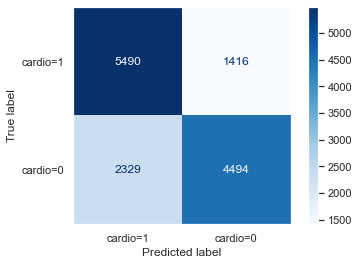

In [39]:
plt.figure(figsize=(10,5))

plot_confusion_matrix(LogReg, X_test, y_test, cmap='Blues', display_labels=['cardio=1','cardio=0'])

plt.grid(False)

<Figure size 720x360 with 0 Axes>

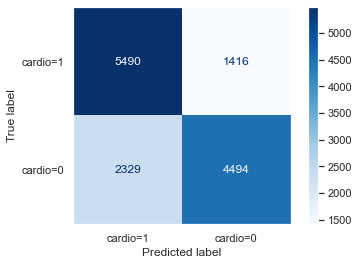

In [40]:
plt.figure(figsize=(10,5))
plot_confusion_matrix(LogReg, X_test, y_test, cmap='Blues', display_labels=['cardio=1','cardio=0'])
plt.grid(False)

In [41]:
from sklearn.metrics import classification_report
LR_Report = classification_report(y_test, y_pred_LR)
print(LR_Report)

              precision    recall  f1-score   support

           0       0.70      0.79      0.75      6906
           1       0.76      0.66      0.71      6823

    accuracy                           0.73     13729
   macro avg       0.73      0.73      0.73     13729
weighted avg       0.73      0.73      0.73     13729



In [42]:
from sklearn.metrics import accuracy_score
a_LR = accuracy_score(y_pred_LR,y_test)
a_LR

0.7272197538058125

# 2. K-nearest neighbour

`scikit-learn` has a direct function for k-nearest neighbour classification, however, the process of selecting the value of `k` requires some trial and error. We can use the "elbow method" to evaluate the most appropriate value of `k` for our dataset.

In [43]:
#This takes a while, please run with caution
from sklearn.neighbors import KNeighborsClassifier
error_rate = []

for K in range(1,40):
 
 knn = KNeighborsClassifier(n_neighbors=K).fit(X_train,y_train)
 pred_k = knn.predict(X_test)
 error_rate.append(np.mean(pred_k != y_test))

Text(0, 0.5, 'Error Rate')

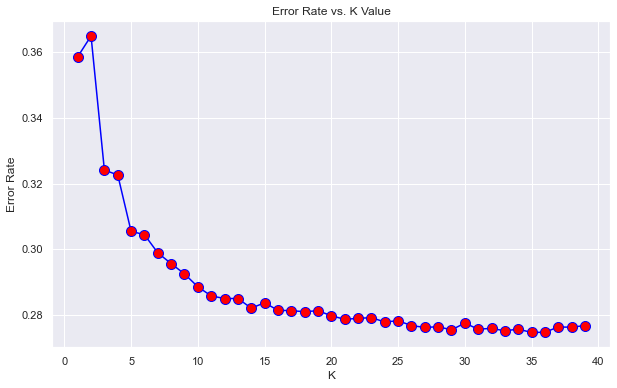

In [44]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', marker='o',
 markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [45]:
print(error_rate.index(min(error_rate)), min(error_rate))

34 0.27467404763639014


The graph shows that as K increases past 5, the error rate stops decreasing precipitously and becomes a more gradual trend. Since we can find the minimum error rate from the calculated data, we can use the best K-value for our test data. Thus, K is 34+1 = **35**

In [46]:
from sklearn.neighbors import KNeighborsClassifier
k = 35
knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
knn

KNeighborsClassifier(n_neighbors=35)

With the ideal value for `k` with us, we can proceed like we did previously with the Logistic Regression, with a confusion matrix and a report. Saving these, we will proceed further and compare our models in the end.

In [47]:
y_pred_KNN = knn.predict(X_test)
y_pred_KNN

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [48]:
y_pred_KNN_prob = knn.predict_proba(X_test)
y_pred_KNN_prob

array([[0.22857143, 0.77142857],
       [0.17142857, 0.82857143],
       [0.88571429, 0.11428571],
       ...,
       [0.14285714, 0.85714286],
       [0.71428571, 0.28571429],
       [0.88571429, 0.11428571]])

In [49]:
print(confusion_matrix(y_test, y_pred_KNN, labels=[1,0]))

[[4604 2219]
 [1552 5354]]


<Figure size 720x360 with 0 Axes>

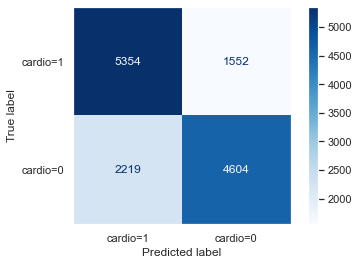

In [50]:
plt.figure(figsize=(10,5))
plot_confusion_matrix(knn, X_test, y_test, cmap='Blues', display_labels=['cardio=1','cardio=0'])
plt.grid(False)

In [51]:
KNN_Report = classification_report(y_test, y_pred_KNN)
print(KNN_Report)

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      6906
           1       0.75      0.67      0.71      6823

    accuracy                           0.73     13729
   macro avg       0.73      0.73      0.72     13729
weighted avg       0.73      0.73      0.72     13729



In [52]:
a_KNN = accuracy_score(y_pred_KNN,y_test)
a_KNN

0.7253259523636099

# 3. Neural Network

The third model we use on our dataset is a simple Artifical Neural Network made using `keras`. Our dataset is sufficiently large to expect reasonable results from the neural network model. We use the Adam optimisation algorithm.

In [53]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [54]:
ann = Sequential()

ann.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu'))
    
ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
ann.add(Dropout(rate=0.5))
ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
ann.add(Dropout(rate=0.5))
 
ann.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))

opt = Adam(learning_rate=0.002)

ann.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])    

In [ ]:
history = ann.fit(np.asarray(X_train), np.asarray(y_train), batch_size = 128, epochs = 100, validation_data=(np.asarray(X_test), np.asarray(y_test)))

Epoch 1/100
430/430 [==============================] - 22s 4ms/step - loss: 0.5990 - accuracy: 0.6878 - val_loss: 0.5557 - val_accuracy: 0.7296
Epoch 2/100
430/430 [==============================] - 1s 2ms/step - loss: 0.5620 - accuracy: 0.7268 - val_loss: 0.5512 - val_accuracy: 0.7324
Epoch 3/100
430/430 [==============================] - 1s 2ms/step - loss: 0.5533 - accuracy: 0.7337 - val_loss: 0.5500 - val_accuracy: 0.7348
Epoch 4/100
430/430 [==============================] - 1s 2ms/step - loss: 0.5604 - accuracy: 0.7255 - val_loss: 0.5489 - val_accuracy: 0.7352
Epoch 5/100
430/430 [==============================] - 1s 2ms/step - loss: 0.5527 - accuracy: 0.7329 - val_loss: 0.5518 - val_accuracy: 0.7307
Epoch 6/100
430/430 [==============================] - 1s 2ms/step - loss: 0.5526 - accuracy: 0.7322 - val_loss: 0.5499 - val_accuracy: 0.7340
Epoch 7/100
430/430 [==============================] - 1s 2ms/step - loss: 0.5487 - accuracy: 0.7349 - val_loss: 0.5482 - val_accuracy: 0.733

Epoch 58/100
430/430 [==============================] - 1s 2ms/step - loss: 0.5433 - accuracy: 0.7379 - val_loss: 0.5475 - val_accuracy: 0.7344
Epoch 59/100
430/430 [==============================] - 1s 2ms/step - loss: 0.5436 - accuracy: 0.7352 - val_loss: 0.5482 - val_accuracy: 0.7329
Epoch 60/100
430/430 [==============================] - 1s 2ms/step - loss: 0.5456 - accuracy: 0.7348 - val_loss: 0.5486 - val_accuracy: 0.7296
Epoch 61/100
430/430 [==============================] - 1s 2ms/step - loss: 0.5459 - accuracy: 0.7357 - val_loss: 0.5484 - val_accuracy: 0.7333
Epoch 62/100
430/430 [==============================] - 1s 2ms/step - loss: 0.5437 - accuracy: 0.7366 - val_loss: 0.5498 - val_accuracy: 0.7306
Epoch 63/100
430/430 [==============================] - 1s 2ms/step - loss: 0.5388 - accuracy: 0.7406 - val_loss: 0.5482 - val_accuracy: 0.7287
Epoch 64/100
430/430 [==============================] - 1s 2ms/step - loss: 0.5433 - accuracy: 0.7375 - val_loss: 0.5492 - val_accuracy:

In [ ]:
print(history.history.keys())

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred_NN = (ann.predict(X_test) > 0.5)*1
y_pred_NN

In [ ]:
a_NN = accuracy_score(y_pred_NN,y_test)
a_NN

In [ ]:
ANN_Report = classification_report(y_test, y_pred_NN)
print(ANN_Report)

In [ ]:
#Since plot_confusion_matrix does not work with non-classifiers (like the NN model), this function is solely for a confusion
#matrix for the NN.
def NN_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cnf_matrix_nn = confusion_matrix(y_test, y_pred_LR, labels=[1,0])

plt.figure()
NN_confusion_matrix(cnf_matrix_nn, classes=['cardio=1','cardio=0'],normalize= False,  title='Confusion matrix')

# Comparision between models

We now have 3 models and the necessary evaluation metrics we need to compare them with each other. First, we will visualise the confusion matrices at a glance.

In [ ]:
#fig, axs = plt.subplots(1,2,figsize=(12,8))

plot_confusion_matrix(LogReg, X_test, y_test, cmap='Blues', display_labels=['cardio=1','cardio=0'])
plt.grid(False)
plot_confusion_matrix(knn, X_test, y_test, cmap='Blues', display_labels=['cardio=1','cardio=0'])
plt.grid(False)

In [ ]:
NN_confusion_matrix(cnf_matrix_nn, classes=['cardio=1','cardio=0'],normalize= False,  title='Confusion matrix')

Plotting accuracies against each other:

In [ ]:
accu = {}
accu["LR"] = a_LR*100
accu["KNN"] = a_KNN*100
accu["ANN"] = a_NN*100
accu

In [ ]:
plt.figure(figsize=(16,5))
sns.barplot(x=list(accu.keys()), y=list(accu.values()), palette='mako')
